#**Obtención del dataset de Kaggle**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Definimos la carpeta base de nuestro proyecto

import os

BASE_FOLDER = "/content/drive/My Drive/TFM_LauraVelaSampedro"
DATASET_FOLDER = BASE_FOLDER + "/monet_dataset"
os.chdir(DATASET_FOLDER)
!pwd

/content/drive/My Drive/TFM_LauraVelaSampedro/monet_dataset


In [ ]:
# Descargamos los dataets de las fotos reales y de las obras de Monet, que utilizaremos en nuestro modelo
# Descomprimimos el archivo descargado

!kaggle competitions download -c gan-getting-started
!unzip gan-getting-started.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Archive:  gan-getting-started.zip
replace monet_jpg/000c1e3bff.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#**Exploración de los datasets**

In [ ]:
import matplotlib.pyplot as plt

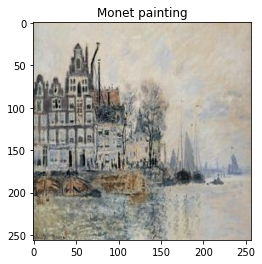

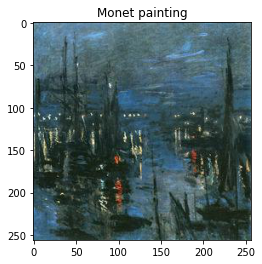

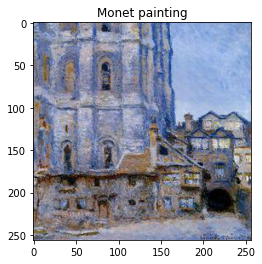

In [ ]:
monet_folder = DATASET_FOLDER + "/monet_jpg/"

count = 0
for filename in os.listdir(monet_folder):
    if filename.endswith("jpg") and count < 3:
      image = plt.imread(monet_folder + filename)
      plt.title('Monet painting')
      plt.imshow(image)
      plt.show()
      count +=1

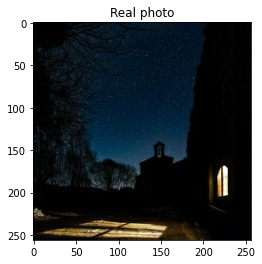

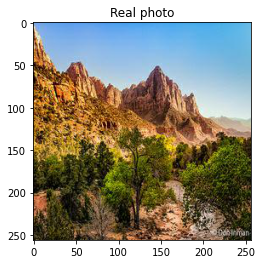

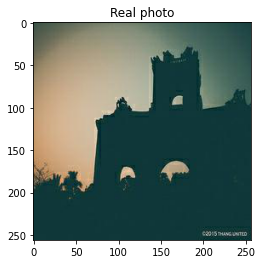

In [ ]:
photo_folder = DATASET_FOLDER + "/photo_jpg/"

count = 0
for filename in os.listdir(photo_folder):
    if filename.endswith("jpg") and count < 3:
      image = plt.imread(photo_folder + filename)
      plt.title('Real photo')
      plt.imshow(image)
      plt.show()
      count +=1

#**Preprocesamiento del dataset**



---



In [ ]:
os.chdir(BASE_FOLDER + "/Keras-GAN/")
!pwd
from cyclegan import cyclegan, data_loader

/content/drive/My Drive/TFM_LauraVelaSampedro/Keras-GAN




---



**Construimos el generador**

In [ ]:
cyclegan.CycleGAN

cyclegan.cyclegan.CycleGAN

In [ ]:
class CycleGAN():
    def __init__(self):
        # Input shape
        self.height = 256
        self.width = 256
        self.channels = 3
        self.img_shape = (self.height, self.width, self.channels)

        # Configure data loader           ------------ Necesito cargar imagenes desde carpeta
        self.dataset_name = 'apple2orange'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,img_res=(self.height, self.width))


        # Calculate output shape of D (PatchGAN) ------- No entiendo bien qué hace aquíí
        patch = int(self.height / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gen_filters = 32
        self.disc_filters = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
        self.d_B.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)

        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gen_filters)
        d2 = conv2d(d1, self.gen_filters*2)
        d3 = conv2d(d2, self.gen_filters*4)
        d4 = conv2d(d3, self.gen_filters*8)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gen_filters*4)
        u2 = deconv2d(u1, d2, self.gen_filters*2)
        u3 = deconv2d(u2, d1, self.gen_filters)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.disc_filters, normalization=False)
        d2 = d_layer(d1, self.disc_filters*2)
        d3 = d_layer(d2, self.disc_filters*4)
        d4 = d_layer(d3, self.disc_filters*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            batch_i, self.data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('datasets/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('datasets/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()


Próximos pasos:

- Estado del arte: barrido cuanto más actual mejor.
Metodología, resultado principales.
Encontrar limitaciones.

- Acondicionamiento
- CycleGan básica
- Transfer style
